# Fine-Tuning and Guidance

In [1]:
# ! pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1
# ! pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu124
# ! pip install ultralytics==8.1.3
# ! pip install diffusers
# ! pip install matplotlib
# ! pip install opencv-python
# ! pip install datasets accelerate wandb open-clip-torch

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Lets use pretrained model to generate some cat images

In [2]:
# image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-cat-256")
image_pipe.to(device)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\Wenbzhan\.cache\huggingface\hub\models--google--ddpm-cat-256\snapshots\82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\Wenbzhan\.cache\huggingface\hub\models--google--ddpm-cat-256\snapshots\82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-cat-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

## Lets Generate 5 cat images

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\diffusers\models\attention_processor.py:2383: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


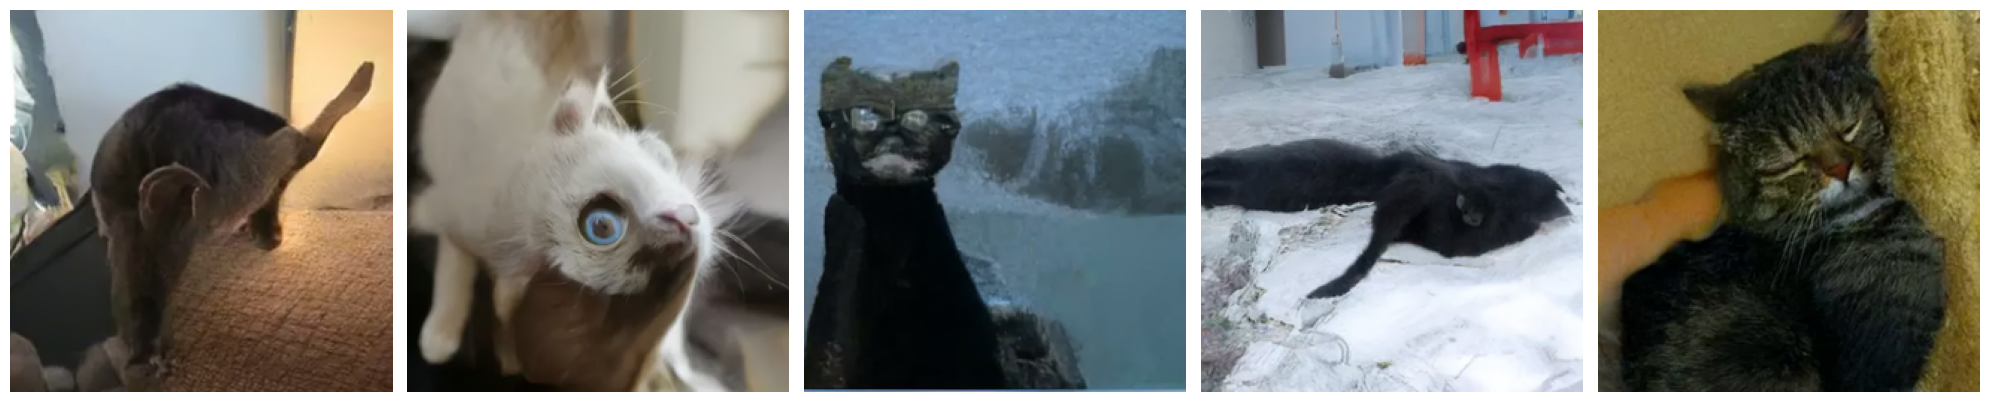

In [4]:
cat_image_list = []
for i in range(0, 5):
    images = image_pipe().images
    cat_image_list.append(images[0])

n_images = len(cat_image_list)

# Create a figure with 1 row and `n_images` columns
fig, axs = plt.subplots(1, n_images, figsize=(20, 5))  # Width 20, Height 5

# Loop through the images and plot them in one row
for idx, image in enumerate(cat_image_list):
    axs[idx].imshow(image)  # Display the image
    axs[idx].axis('off')    # Remove axis for cleaner display

# Display the plots
plt.tight_layout()
plt.show()

It takes very long time

100%|██████████| 300/300 [00:16<00:00, 18.43it/s]


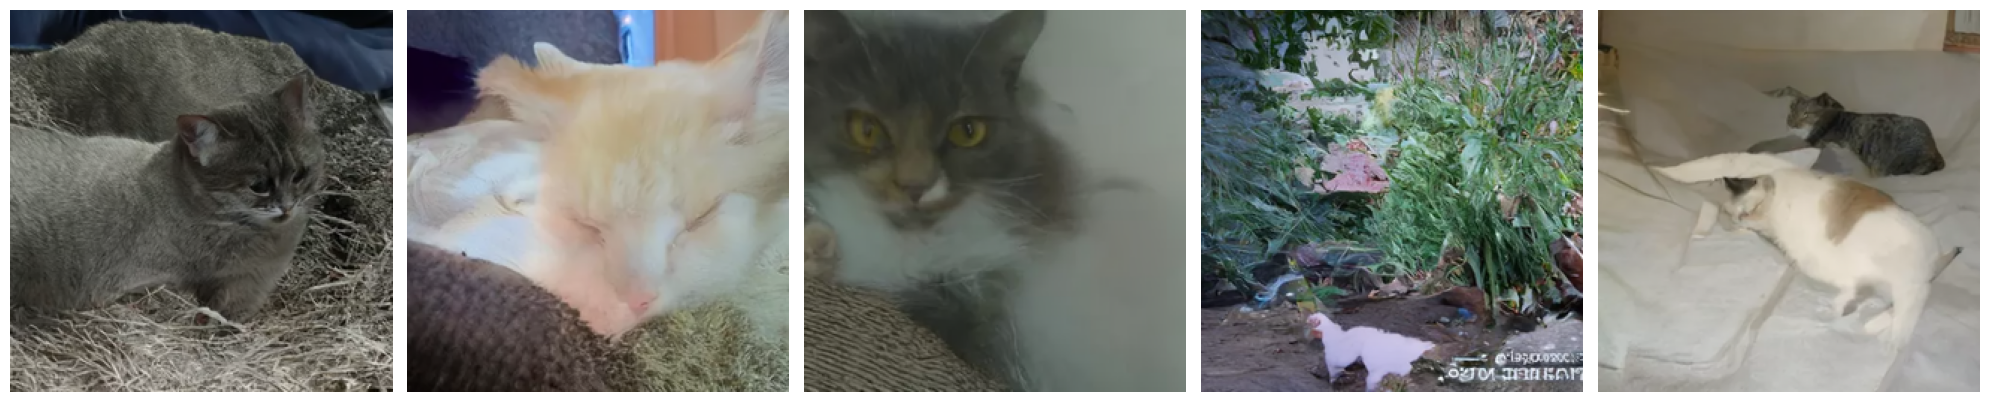

In [5]:
cat_image_list = []
for i in range(0, 5):
    images = image_pipe(num_inference_steps=300).images
    cat_image_list.append(images[0])

n_images = len(cat_image_list)

# Create a figure with 1 row and `n_images` columns
fig, axs = plt.subplots(1, n_images, figsize=(20, 5))  # Width 20, Height 5

# Loop through the images and plot them in one row
for idx, image in enumerate(cat_image_list):
    axs[idx].imshow(image)  # Display the image
    axs[idx].axis('off')    # Remove axis for cleaner display

# Display the plots
plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

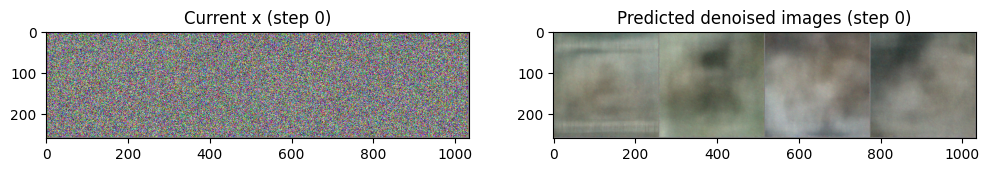

100it [00:18,  5.54it/s]

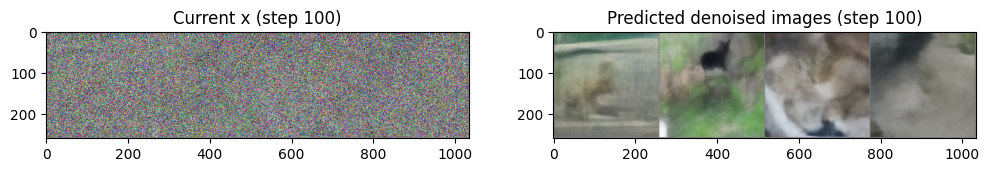

200it [00:36,  5.50it/s]

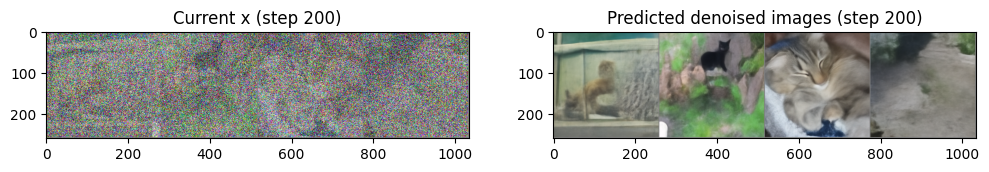

300it [00:54,  5.48it/s]

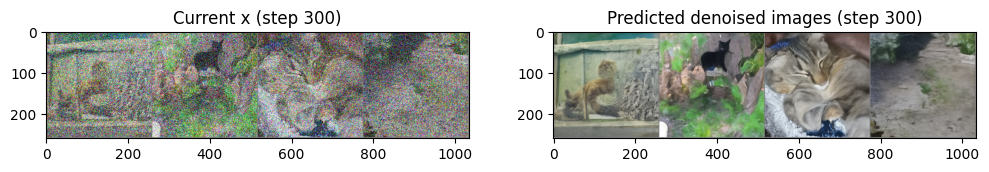

399it [01:13,  5.47it/s]

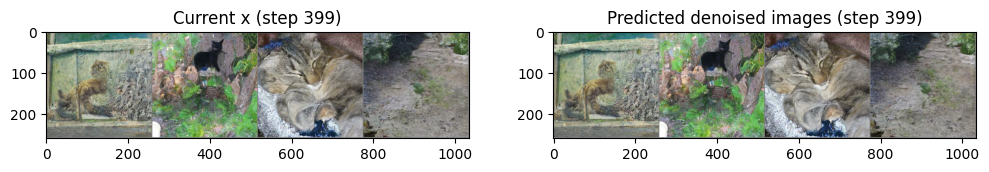

400it [01:13,  5.43it/s]


In [7]:
# Replace the default scheduler with DDIMScheduler (if you want DDIM behavior)
scheduler = DDIMScheduler.from_pretrained("google/ddpm-cat-256")
num_inference_steps = 400
scheduler.set_timesteps(num_inference_steps=num_inference_steps)
image_pipe.scheduler = scheduler

# Random starting point (batch of 4 images, 3 channels, 256x256 resolution)
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256x256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(image_pipe.scheduler.timesteps)):
    # Prepare model input
    model_input = image_pipe.scheduler.scale_model_input(x, t)
    # Get the prediction from the UNet (predict the noise)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    # Calculate what the updated sample should look like using the scheduler
    scheduler_output = image_pipe.scheduler.step(noise_pred, t, x)
    # Update x for the next iteration
    x = scheduler_output.prev_sample
    # Occasionally display the intermediate results
    if i % 100 == 0 or i == len(image_pipe.scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        # Display the current `x` (partially denoised image)
        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)  # Clip and normalize image for display
        axs[0].set_title(f"Current x (step {i})")
        # Display the predicted "clean" image (denoised image)
        pred_x0 = scheduler_output.pred_original_sample  # Original prediction from the scheduler
        if pred_x0 is not None:  # Not all schedulers support pred_original_sample
            grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
            axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[1].set_title(f"Predicted denoised images (step {i})")
        else:
            axs[1].set_title(f"Predicted denoised images (unavailable)")

        plt.show()


In [9]:
dataset_name = "timm/oxford-iiit-pet"
dataset = load_dataset(dataset_name, split="train")

# Choose the cat breed you want to focus on
target_breed = "british_shorthair"  # Change this to any breed name in the dataset
breed_names = dataset.features['label'].names  # Get the list of all breed names

# Check if the breed exists in the dataset
if target_breed not in breed_names:
    raise ValueError(f"Breed '{target_breed}' not found in dataset. Available breeds: {breed_names}")

# Get the breed index for the target breed
breed_index = breed_names.index(target_breed)

# Filter dataset to only include the specific cat breed
filtered_dataset = dataset.filter(lambda example: example['label'] == breed_index)

print(f"Number of images for {target_breed}: {len(filtered_dataset)}")



image_size = 256  # @param
batch_size = 4  # @param

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


filtered_dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

Number of images for british_shorthair: 100
Previewing batch:


  0%|          | 0/25 [00:00<?, ?it/s]c:\Users\Wenbzhan\.conda\envs\DiffusionModel\lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


Epoch 0 average loss: 0.011994956083362922


100%|██████████| 25/25 [00:13<00:00,  1.89it/s]

Epoch 1 average loss: 0.01797220600070432


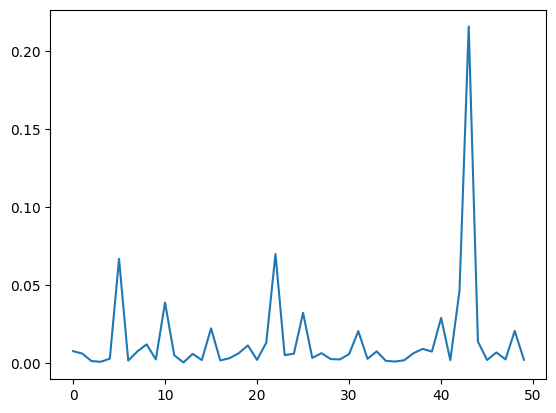

In [10]:
num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)

400it [02:21,  2.82it/s]


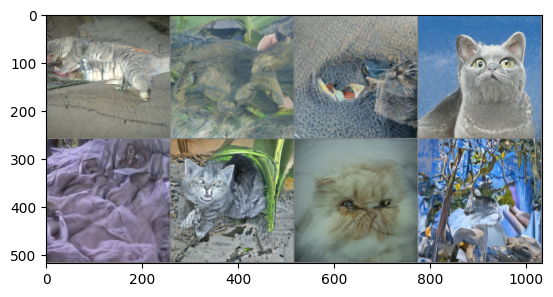

In [11]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

#### Save your model

In [ ]:
# torch.save(image_pipe, target_breed+".pth")